<a href="https://colab.research.google.com/github/ykato27/GAN/blob/main/StyleGAN_nada.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to StyleGAN-NADA: CLIP-Guided Domain Adaptation of Image Generators!

# Step 1: Setup required libraries and models. 
This may take a few minutes.

You may optionally enable downloads with pydrive in order to authenticate and avoid drive download limits when fetching pre-trained ReStyle and StyleGAN2 models.

In [1]:
# @title Setup
%tensorflow_version 1.x

import os

from google.colab import auth
from oauth2client.client import GoogleCredentials
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive

pretrained_model_dir = os.path.join("/content", "models")
os.makedirs(pretrained_model_dir, exist_ok=True)

restyle_dir = os.path.join("/content", "restyle")
stylegan_ada_dir = os.path.join("/content", "stylegan_ada")
stylegan_nada_dir = os.path.join("/content", "stylegan_nada")

output_dir = os.path.join("/content", "output")

output_model_dir = os.path.join(output_dir, "models")
output_image_dir = os.path.join(output_dir, "images")

download_with_pydrive = False  # @param {type:"boolean"}


class Downloader(object):
    def __init__(self, use_pydrive):
        self.use_pydrive = use_pydrive

        if self.use_pydrive:
            self.authenticate()

    def authenticate(self):
        auth.authenticate_user()
        gauth = GoogleAuth()
        gauth.credentials = GoogleCredentials.get_application_default()
        self.drive = GoogleDrive(gauth)

    def download_file(self, file_id, file_dst):
        if self.use_pydrive:
            downloaded = self.drive.CreateFile({"id": file_id})
            downloaded.FetchMetadata(fetch_all=True)
            downloaded.GetContentFile(file_dst)
        else:
            !gdown --id $file_id -O $file_dst


downloader = Downloader(download_with_pydrive)

# install requirements
!git clone https://github.com/yuval-alaluf/restyle-encoder.git $restyle_dir

downloader.download_file(
    "1sw6I2lRIB0MpuJkpc8F5BJiSZrc0hjfE",
    os.path.join(pretrained_model_dir, "restyle_psp_ffhq_encode.pt"),
)
downloader.download_file(
    "1e2oXVeBPXMQoUoC_4TNwAWpOPpSEhE_e",
    os.path.join(pretrained_model_dir, "restyle_e4e_ffhq_encode.pt"),
)

!wget https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip
!sudo unzip ninja-linux.zip -d /usr/local/bin/
!sudo update-alternatives --install /usr/bin/ninja ninja /usr/local/bin/ninja 1 --force

!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

!git clone https://github.com/NVlabs/stylegan2-ada/ $stylegan_ada_dir
!git clone https://github.com/rinongal/stylegan-nada.git $stylegan_nada_dir

import sys
from argparse import Namespace

import numpy as np
import torch
import torchvision.transforms as transforms
from PIL import Image

sys.path.append(restyle_dir)
sys.path.append(stylegan_nada_dir)
sys.path.append(os.path.join(stylegan_nada_dir, "ZSSGAN"))

from restyle.models.e4e import e4e
from restyle.models.psp import pSp
from restyle.utils.common import tensor2im

device = "cuda"

%load_ext autoreload
%autoreload 2

import gdown

gdown.download(
    "https://drive.google.com/uc?id=1DiC2AZRt7GDSnLsE--FOqOTnMWwV6mTr",
    "./sample.zip",
    quiet=False,
)
! unzip sample.zip

TensorFlow 1.x selected.
Cloning into '/content/restyle'...
remote: Enumerating objects: 252, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 252 (delta 20), reused 19 (delta 14), pack-reused 215
Receiving objects: 100% (252/252), 24.82 MiB | 26.20 MiB/s, done.
Resolving deltas: 100% (81/81), done.
Downloading...
From: https://drive.google.com/uc?id=1sw6I2lRIB0MpuJkpc8F5BJiSZrc0hjfE
To: /content/models/restyle_psp_ffhq_encode.pt
955MB [00:24, 39.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1e2oXVeBPXMQoUoC_4TNwAWpOPpSEhE_e
To: /content/models/restyle_e4e_ffhq_encode.pt
959MB [00:21, 45.6MB/s]
--2021-08-15 02:23:16--  https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github-releases.githubuserco

Downloading...
From: https://drive.google.com/uc?id=1DiC2AZRt7GDSnLsE--FOqOTnMWwV6mTr
To: /content/sample.zip
100%|██████████| 1.57M/1.57M [00:00<00:00, 8.49MB/s]


Archive:  sample.zip
  inflating: sample/001.jpg          
  inflating: sample/002.jpg          
  inflating: sample/003.jpg          
  inflating: sample/004.jpg          
  inflating: sample/005.jpg          
  inflating: sample/006.jpg          
  inflating: sample/007.jpg          
  inflating: sample/008.jpg          
  inflating: sample/009.jpg          
  inflating: sample/010.jpg          
  inflating: sample/011.jpg          
  inflating: sample/012.jpg          
  inflating: sample/013.jpg          
  inflating: sample/014.jpg          
  inflating: sample/015.jpg          
  inflating: sample/016.jpg          


# Step 2: Choose a model type.
Model will be downloaded and converted to a pytorch compatible version.

Re-runs of the cell with the same model will re-use the previously downloaded version. Feel free to experiment and come back to previous models :)

In [2]:
source_model_type = "ffhq"  # @param['ffhq', 'cat', 'dog', 'church', 'horse', 'car']

source_model_download_path = {
    "ffhq": "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada/pretrained/ffhq.pkl",
    "cat": "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada/pretrained/afhqcat.pkl",
    "dog": "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada/pretrained/afhqdog.pkl",
    "church": "1iDo5cUgbwsJEt2uwfgDy_iPlaT-lLZmi",
    "car": "1i-39ztut-VdUVUiFuUrwdsItR--HF81w",
    "horse": "1irwWI291DolZhnQeW-ZyNWqZBjlWyJUn",
}

model_names = {
    "ffhq": "ffhq.pkl",
    "cat": "afhqcat.pkl",
    "dog": "afhqdog.pkl",
    "church": "stylegan2-church-config-f.pkl",
    "car": "stylegan2-car-config-f.pkl",
    "horse": "stylegan2-horse-config-f.pkl",
}

download_string = source_model_download_path[source_model_type]
file_name = model_names[source_model_type]
pt_file_name = file_name.split(".")[0] + ".pt"

dataset_sizes = {
    "ffhq": 1024,
    "cat": 512,
    "dog": 512,
    "church": 256,
    "horse": 256,
    "car": 512,
}

if not os.path.isfile(os.path.join(pretrained_model_dir, file_name)):
    print("Downloading chosen model...")

    if download_string.endswith(".pkl"):
        !wget $download_string -O $pretrained_model_dir/$file_name
    else:
        downloader.download_file(
            download_string, os.path.join(pretrained_model_dir, file_name)
        )

if not os.path.isfile(os.path.join(pretrained_model_dir, pt_file_name)):
    print("Converting sg2 model. This may take a few minutes...")

    tf_path = next(filter(lambda x: "tensorflow" in x, sys.path), None)
    py_path = tf_path + f":{stylegan_nada_dir}/ZSSGAN"
    convert_script = os.path.join(stylegan_nada_dir, "convert_weight.py")
    !PYTHONPATH=$py_path python $convert_script --repo $stylegan_ada_dir --gen $pretrained_model_dir/$file_name

--2021-08-15 02:24:25--  https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada/pretrained/ffhq.pkl
Resolving nvlabs-fi-cdn.nvidia.com (nvlabs-fi-cdn.nvidia.com)... 13.225.143.70, 13.225.143.125, 13.225.143.41, ...
Connecting to nvlabs-fi-cdn.nvidia.com (nvlabs-fi-cdn.nvidia.com)|13.225.143.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 381646055 (364M) [binary/octet-stream]
Saving to: ‘/content/models/ffhq.pkl’

/content/models/ffh 100%[===================>] 363.97M   177MB/s    in 2.1s    

2021-08-15 02:24:28 (177 MB/s) - ‘/content/models/ffhq.pkl’ saved [381646055/381646055]

Converting sg2 model. This may take a few minutes...
Setting up TensorFlow plugin "fused_bias_act.cu": Compiling... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Compiling... Loading... Done.
/content/stylegan_nada/ZSSGAN/op/conv2d_gradfix.py:89: UserWarning: conv2d_gradfix not supported on PyTorch 1.9.0+cu102. Falling back to torch.nn.functional.conv2d().
  f"conv2d_grad

# Step 3: Train the model.
Describe your source and target class. These describe the direction of change you're trying to apply (e.g. "photo" to "sketch", "dog" to "the joker" or "dog" to "avocado dog").

We reccomend leaving the 'improve shape' button unticked at first, as it will lead to an increase in running times and is often not needed.
For more drastic changes, turn it on and increase the number of iterations.

As a rule of thumb:
- Style and minor domain changes ('photo' -> 'sketch') require ~200-400 iterations.
- Identity changes ('person' -> 'taylor swift') require ~150-200 iterations.
- Simple in-domain changes ('face' -> 'smiling face') may require as few as 50.

> Updates:
> 03/08 - Added support for saving model checkpoints. If you want to save, set save_interval > 0.



Loading base models...


100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 202MiB/s]
100%|███████████████████████████████████████| 244M/244M [00:06<00:00, 42.3MiB/s]
100%|████████████████████████████████████████| 335M/335M [00:02<00:00, 149MiB/s]


Models loaded! Starting training...


  0%|          | 0/151 [00:00<?, ?it/s]

/content/stylegan_nada/ZSSGAN/op/conv2d_gradfix.py:89: UserWarning: conv2d_gradfix not supported on PyTorch 1.9.0+cu102. Falling back to torch.nn.functional.conv2d().
  f"conv2d_gradfix not supported on PyTorch {torch.__version__}. Falling back to torch.nn.functional.conv2d()."
/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


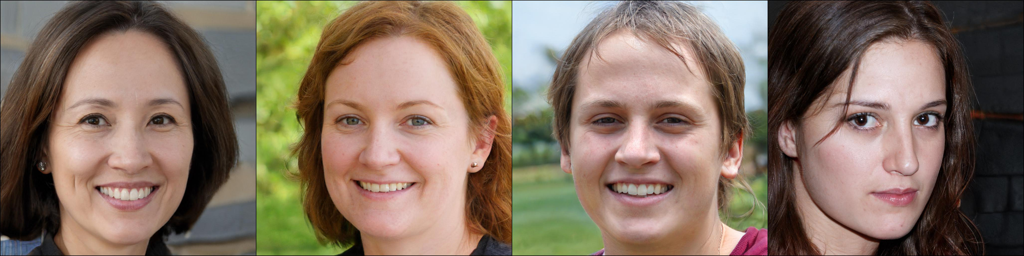

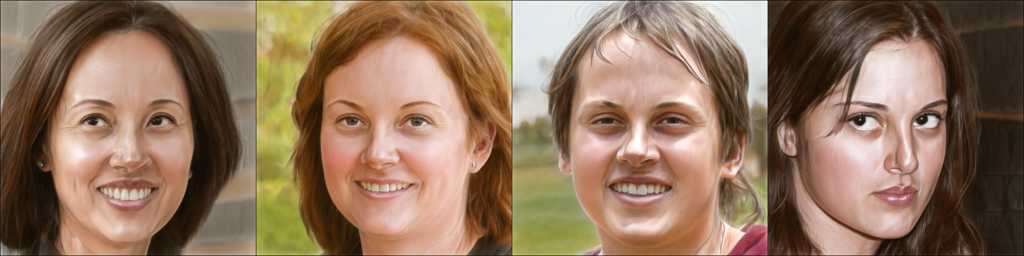

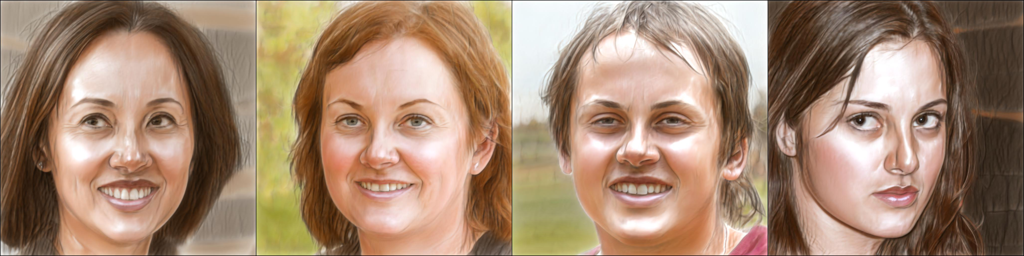

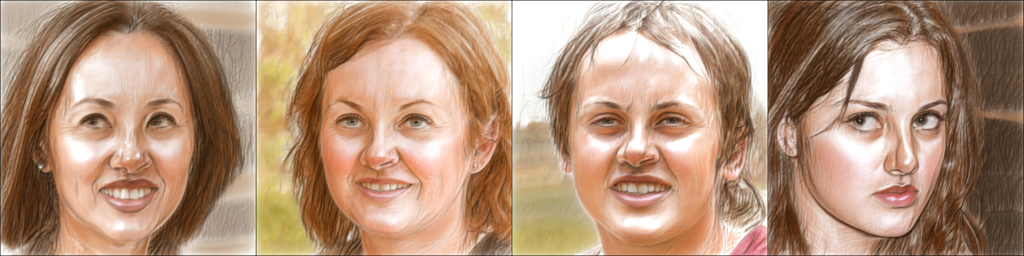

In [3]:
import numpy as np
import torch
from IPython.display import display
from tqdm import notebook
from ZSSGAN.model.ZSSGAN import ZSSGAN
from ZSSGAN.utils.file_utils import save_images
from ZSSGAN.utils.training_utils import mixing_noise

source_class = "Photo"  # @param {"type": "string"}
target_class = "Sketch"  # @param {"type": "string"}

improve_shape = False  # @param{type:"boolean"}

model_choice = ["ViT-B/32", "ViT-B/16"]
model_weights = [1.0, 0.0]

if improve_shape:
    model_weights[1] = 1.0

mixing = 0.9 if improve_shape else 0.0

auto_layers_k = (
    int(2 * (2 * np.log2(dataset_sizes[source_model_type]) - 2) / 3)
    if improve_shape
    else 0
)
auto_layer_iters = 1 if improve_shape else 0

training_iterations = 151  # @param {type: "integer"}
output_interval = 50  # @param {type: "integer"}
save_interval = 0  # @param {type: "integer"}

training_args = {
    "size": dataset_sizes[source_model_type],
    "batch": 2,
    "n_sample": 4,
    "output_dir": output_dir,
    "lr": 0.002,
    "frozen_gen_ckpt": os.path.join(pretrained_model_dir, pt_file_name),
    "train_gen_ckpt": os.path.join(pretrained_model_dir, pt_file_name),
    "iter": training_iterations,
    "source_class": source_class,
    "target_class": target_class,
    "lambda_direction": 1.0,
    "lambda_patch": 0.0,
    "lambda_global": 0.0,
    "lambda_texture": 0.0,
    "lambda_manifold": 0.0,
    "auto_layer_k": auto_layers_k,
    "auto_layer_iters": auto_layer_iters,
    "auto_layer_batch": 8,
    "output_interval": 50,
    "clip_models": model_choice,
    "clip_model_weights": model_weights,
    "mixing": mixing,
    "phase": None,
    "sample_truncation": 0.7,
    "save_interval": save_interval,
}

args = Namespace(**training_args)

print("Loading base models...")
net = ZSSGAN(args)
print("Models loaded! Starting training...")

g_reg_ratio = 4 / 5

g_optim = torch.optim.Adam(
    net.generator_trainable.parameters(),
    lr=args.lr * g_reg_ratio,
    betas=(0 ** g_reg_ratio, 0.99 ** g_reg_ratio),
)

# Set up output directories.
sample_dir = os.path.join(args.output_dir, "sample")
ckpt_dir = os.path.join(args.output_dir, "checkpoint")

os.makedirs(sample_dir, exist_ok=True)
os.makedirs(ckpt_dir, exist_ok=True)

seed = 3  # @param {"type": "integer"}

torch.manual_seed(seed)
np.random.seed(seed)

# Training loop
fixed_z = torch.randn(args.n_sample, 512, device=device)

for i in notebook.tqdm(range(args.iter)):
    net.train()

    sample_z = mixing_noise(args.batch, 512, args.mixing, device)

    [sampled_src, sampled_dst], clip_loss = net(sample_z)

    net.zero_grad()
    clip_loss.backward()

    g_optim.step()

    if i % output_interval == 0:
        net.eval()

        with torch.no_grad():
            [sampled_src, sampled_dst], loss = net(
                [fixed_z], truncation=args.sample_truncation
            )

            if source_model_type == "car":
                sampled_dst = sampled_dst[:, :, 64:448, :]

            grid_rows = 4

            save_images(sampled_dst, sample_dir, "dst", grid_rows, i)

            img = Image.open(
                os.path.join(sample_dir, f"dst_{str(i).zfill(6)}.jpg")
            ).resize((1024, 256))
            display(img)

    if (args.save_interval > 0) and (i > 0) and (i % args.save_interval == 0):
        torch.save(
            {
                "g_ema": net.generator_trainable.generator.state_dict(),
                "g_optim": g_optim.state_dict(),
            },
            f"{ckpt_dir}/{str(i).zfill(6)}.pt",
        )

# Step 4: Generate samples with the new model

/content/stylegan_nada/ZSSGAN/op/conv2d_gradfix.py:89: UserWarning: conv2d_gradfix not supported on PyTorch 1.9.0+cu102. Falling back to torch.nn.functional.conv2d().
  f"conv2d_gradfix not supported on PyTorch {torch.__version__}. Falling back to torch.nn.functional.conv2d()."
/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


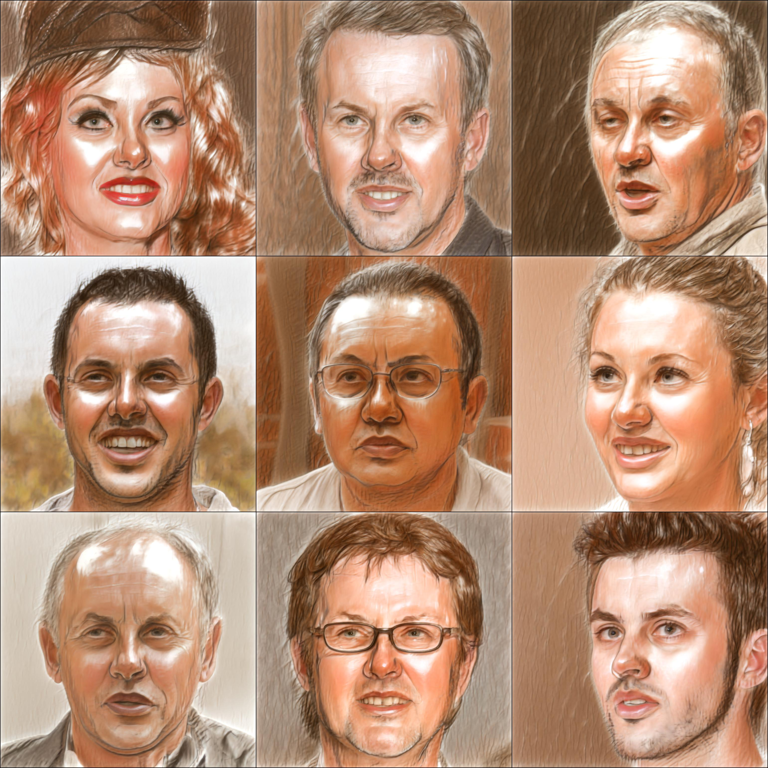

In [4]:
truncation = 0.7  # @param {type:"slider", min:0, max:1, step:0.05}

samples = 9

with torch.no_grad():
    net.eval()
    sample_z = torch.randn(samples, 512, device=device)

    [sampled_src, sampled_dst], loss = net([sample_z], truncation=truncation)

    if source_model_type == "car":
        sampled_dst = sampled_dst[:, :, 64:448, :]

    grid_rows = int(samples ** 0.5)

    save_images(sampled_dst, sample_dir, "sampled", grid_rows, 0)

    display(
        Image.open(os.path.join(sample_dir, f"sampled_{str(0).zfill(6)}.jpg")).resize(
            (768, 768)
        )
    )

## Editing a real image with Re-Style inversion (currently only FFHQ inversion is supported):

Step 1: Set up the Re-Style model.

Choose the pSp model for better reconstructions. 
We found that for some extreme modifications (typically those which require 500+ training iterations), e4e may perform better.

In [5]:
encoder_type = "psp"  # @param['psp', 'e4e']

restyle_experiment_args = {
    "model_path": os.path.join(
        pretrained_model_dir, f"restyle_{encoder_type}_ffhq_encode.pt"
    ),
    "transform": transforms.Compose(
        [
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
        ]
    ),
}

model_path = restyle_experiment_args["model_path"]
ckpt = torch.load(model_path, map_location="cpu")

opts = ckpt["opts"]

opts["checkpoint_path"] = model_path
opts = Namespace(**opts)

restyle_net = (pSp if encoder_type == "psp" else e4e)(opts)

restyle_net.eval()
restyle_net.cuda()
print("Model successfully loaded!")

Loading ReStyle pSp from checkpoint: /content/models/restyle_psp_ffhq_encode.pt
Model successfully loaded!


Step 2: Align and invert an image

Done.
Aligned image has shape: (256, 256)


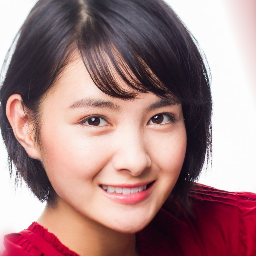

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [6]:
def run_alignment(image_path):
    import dlib
    from scripts.align_faces_parallel import align_face

    if not os.path.exists("shape_predictor_68_face_landmarks.dat"):
        print("Downloading files for aligning face image...")
        os.system(
            "wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2"
        )
        os.system("bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2")
        print("Done.")
    predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
    aligned_image = align_face(filepath=image_path, predictor=predictor)
    print("Aligned image has shape: {}".format(aligned_image.size))
    return aligned_image


image_path = "/content/sample/001.jpg"  # @param {'type': 'string'}
original_image = Image.open(image_path).convert("RGB")

input_image = run_alignment(image_path)

display(input_image)

img_transforms = restyle_experiment_args["transform"]
transformed_image = img_transforms(input_image)


def get_avg_image(net):
    avg_image = net(
        net.latent_avg.unsqueeze(0),
        input_code=True,
        randomize_noise=False,
        return_latents=False,
        average_code=True,
    )[0]
    avg_image = avg_image.to("cuda").float().detach()
    return avg_image


opts.n_iters_per_batch = 5
opts.resize_outputs = False  # generate outputs at full resolution

from restyle.utils.inference_utils import run_on_batch

with torch.no_grad():
    avg_image = get_avg_image(restyle_net)
    result_batch, result_latents = run_on_batch(
        transformed_image.unsqueeze(0).cuda(), restyle_net, opts, avg_image
    )

Step 3: Convert the image to the new domain

/content/stylegan_nada/ZSSGAN/op/conv2d_gradfix.py:89: UserWarning: conv2d_gradfix not supported on PyTorch 1.9.0+cu102. Falling back to torch.nn.functional.conv2d().
  f"conv2d_gradfix not supported on PyTorch {torch.__version__}. Falling back to torch.nn.functional.conv2d()."
/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


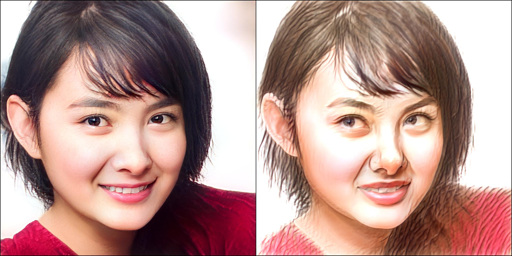

In [7]:
# @title Convert inverted image.
inverted_latent = torch.Tensor(result_latents[0][4]).cuda().unsqueeze(0).unsqueeze(1)

with torch.no_grad():
    net.eval()

    [sampled_src, sampled_dst] = net(inverted_latent, input_is_latent=True)[0]

    joined_img = torch.cat([sampled_src, sampled_dst], dim=0)
    save_images(joined_img, sample_dir, "joined", 2, 0)
    display(
        Image.open(os.path.join(sample_dir, f"joined_{str(0).zfill(6)}.jpg")).resize(
            (512, 256)
        )
    )